<h1><u>Feature engineering and classification of digits</u></h1>
<h3>May 2018</h3>


<ul>
<li>I did a little bit of feature engineering by applying transformations to the train data, which increased significanlty the variety of digits for training.</li>
<ul><li>That is: I rotated, translated, resized and blured digits, and appended the transformed digits together. Essentially, I made "new" digits.</li></ul>
<li>Then I wrote my own grid search function (gridSeach_No_CV) because I did not want to train my models on partial data (kfold) from the train data set. Instead, I used the test data set to evaluate models' performance. </li>
</ul>

<ul><li>I trainned several algorithms: Random forest performed best with an accuracy of 99.22%</li></ul>

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
import warnings
import scipy.stats as st
from sklearn.pipeline import Pipeline
import itertools as it
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from PIL import Image
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
#############################################
###########  Feature engineering  ########### 
#############################################


def feature_engineering(d, processing):
    '''appends transformed data set into one: n x 257'''
    d_ = np.copy(d)
    for i in processing.items():
        if i[0] == 'shrink':
            for j in i[1]:
                d_ = np.append(d_, shrink_dataset(d, j), axis=0)
        elif i[0] == 'blur':
            for j in i[1]:
                d_ = np.append(d_, blur_dataset(d, j), axis=0)
        elif i[0] == 'shift':
            for j in i[1]:
                d_ = np.append(d_, shift_dataset(d, j[0],j[1]), axis=0)
        elif i[0] == 'rotate':
            for j in i[1]:
                d_ = np.append(d_, rotate_dataset(d, j), axis=0)
        else:
            print('Transformation unknown')
    return d_


def shrink_train(d):
    '''Appends 3 datasets together: one normal size, one shrinked by 87.5% and one shrinked by 75%'''
    d_ = np.copy(d)
    d_ = np.append(d_, shrink_dataset(d_, .875), axis=0)
    d_ = np.append(d_, shrink_dataset(d_, .75), axis=0)
    return blur_dataset(d_, 3)

def gkernel(kernlen=21, nsig=3):
    '''Creates a kernel to blur'''
    # Build a 2D Gaussian kernel array
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def blurer(vector_img, k):
    '''Use gkernel to blur a digit'''
    a = vector_img.reshape(16,16)
    kernel = gkernel(k)
    kernel = kernel / np.sum(kernel)
    arraylist = []
    for y in range(3):
        temparray = np.copy(a)
        temparray = np.roll(temparray, y - 1, axis=0)
        for x in range(3):
            temparray_X = np.copy(temparray)
            temparray_X = np.roll(temparray_X, x - 1, axis=1)*kernel[y,x]
            arraylist.append(temparray_X)
    arraylist = np.array(arraylist)
    arraylist_sum = np.sum(arraylist, axis=0)
    return arraylist_sum.reshape(256, -1)[:,0]

def rotator(vector_img, theta):
    '''Rotates a digit'''
    r = rotate(vector_img.reshape(16,16), theta)
    r[r==0]= -1 
    offset = r.shape[0] - 16
    start = 0 
    end = 0
    start = offset // 2
    end = start + offset % 2
    if end == 0:
        r = r[start:, start:]
    else:
        r = r[start:-end, start:-end]
    return r.reshape(256, -1)[:,0]

def shifter(vector_img, d_x, d_y):
    '''Translate a digit in 2D'''
    s = shift(vector_img.reshape(16,16), (-d_y, d_x))
    s[s==0]= -1 
    offset = s.shape[0] - 16
    start = 0 
    end = 0
    start = offset // 2
    end = start + offset % 2
    if end == 0:
        s = s[start:, start:]
    else:
        s = s[start:-end, start:-end]
    return s.reshape(256, -1)[:,0]

def shrinker(vector_img, size):
    '''Shrinks a digit by 75% or 87.5%'''
    # reduce 12x12 and pad in black
    arr = Image.fromarray(vector_img.reshape(16,16))
    px, pd = 0,0
    if size == 0.75:
        px = 12
        pd = 2
    elif size == 0.875:
        px = 14
        pd = 1
    else:
        px = 16
        pd = 0
    arr_ = np.array(arr.resize((px, px),Image.ANTIALIAS))
    return np.pad(arr_,(pd, pd), 'constant', constant_values=(-1)).reshape(256,-1)[:,0]
    
def shrink_dataset(d, size):
    '''Use shrkinker to shrink entire dataset'''
    mtx = np.zeros(d.shape)
    for i in range(mtx.shape[0]):
        mtx[i,0] = d[i, 0].astype(int)
        mtx[i, 1:] = shrinker(d[i, 1:], size)
    return mtx    

def shift_dataset(d, d_x, d_y):
    '''Use shifter to translate entire dataset'''
    mtx = np.zeros(d.shape)
    for i in range(mtx.shape[0]):
        mtx[i,0] = d[i, 0].astype(int)
        mtx[i, 1:] = shifter(d[i, 1:], d_x, d_y)
    return mtx

def rotate_dataset(d, theta):
    '''Use rotator to rotate entire dataset'''
    mtx = np.zeros(d.shape)
    for i in range(mtx.shape[0]):
        mtx[i,0] = d[i, 0].astype(int)
        mtx[i, 1:] = rotator(d[i, 1:], -theta)
    return mtx
     
def blur_dataset(d, k=5):
    '''Use blurer to blur entire dataset'''
    if k == 0:
        return d
    mtx = np.zeros(d.shape)
    for i in range(mtx.shape[0]):
        mtx[i,0] = d[i, 0].astype(int)
        mtx[i, 1:] = blurer(d[i, 1:], k)
    return mtx  

def get_X(d):
    return d[:, 1:]

def get_y(d):
    return d[:, 0]

def Xy(X, y):
    return np.concatenate((y.reshape(-1,1),X), axis=1)

################################################
########### Plotting transformation  ########### 
################################################

def show_4_rotations(d, param):
    print('Rotating...')
    f,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4,  figsize=(10,10))
    ax1.imshow(rotate_dataset(d, param[0])[1, 1:].reshape(16,16),'gray')
    ax2.imshow(rotate_dataset(d, param[1])[1, 1:].reshape(16,16),'gray')
    ax3.imshow(rotate_dataset(d, param[2])[1, 1:].reshape(16,16),'gray')
    ax4.imshow(rotate_dataset(d, param[3])[1, 1:].reshape(16,16),'gray')
    ax1.set_title(str(param[0]) + ' degrees')
    ax2.set_title(str(param[1])  + ' degrees')
    ax3.set_title(str(param[2]) + ' degrees')
    ax4.set_title(str(param[3])  + ' degrees')
    ax1.get_xaxis().set_ticks([]); ax1.get_yaxis().set_ticks([])
    ax2.get_xaxis().set_ticks([]); ax2.get_yaxis().set_ticks([])
    ax3.get_xaxis().set_ticks([]); ax3.get_yaxis().set_ticks([])
    ax4.get_xaxis().set_ticks([]); ax4.get_yaxis().set_ticks([])

    
def show_3_shrinks(d, param):
    print('Shrinking...')
    f,(ax1,ax2, ax3) = plt.subplots(1, 3,  figsize=(8,8))
    ax1.imshow(shrink_dataset(d, param[0])[1, 1:].reshape(16,16),'gray')
    ax2.imshow(shrink_dataset(d, param[1])[1, 1:].reshape(16,16),'gray')
    ax3.imshow(shrink_dataset(d, param[2])[1, 1:].reshape(16,16),'gray')
    ax1.set_title(str(param[0]) + ' percent')
    ax2.set_title(str(param[1]) + ' percent')
    ax3.set_title(str(param[2])  + 'percent')
    ax1.get_xaxis().set_ticks([]); ax1.get_yaxis().set_ticks([])
    ax2.get_xaxis().set_ticks([]); ax2.get_yaxis().set_ticks([])
    ax3.get_xaxis().set_ticks([]); ax3.get_yaxis().set_ticks([])
   
    
def show_4_shifts(d, param):
    print('Translating....')
    f,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4,  figsize=(10,10))
    ax1.imshow(shift_dataset(d, param[0][0],param[0][1])[1, 1:].reshape(16,16),'gray')
    ax2.imshow(shift_dataset(d, param[1][0],param[1][1])[1, 1:].reshape(16,16),'gray')
    ax3.imshow(shift_dataset(d, param[2][0],param[2][1])[1, 1:].reshape(16,16),'gray')
    ax4.imshow(shift_dataset(d, param[3][0],param[3][1])[1, 1:].reshape(16,16),'gray')
    ax1.set_title(str(param[0][0]) + ':h, ' + str(param[0][1]) + ':v')
    ax2.set_title(str(param[1][0]) + ':h, ' + str(param[1][1]) + ':v')
    ax3.set_title(str(param[2][0]) + ':h, ' + str(param[2][1]) + ':v')
    ax4.set_title(str(param[3][0]) + ':h, ' + str(param[3][1]) + ':v') 
    ax1.get_xaxis().set_ticks([]); ax1.get_yaxis().set_ticks([])
    ax2.get_xaxis().set_ticks([]); ax2.get_yaxis().set_ticks([])
    ax3.get_xaxis().set_ticks([]); ax3.get_yaxis().set_ticks([])
    ax4.get_xaxis().set_ticks([]); ax4.get_yaxis().set_ticks([])
    
    
def show_3_blur(d, param):
    print('Bluring...')
    f,(ax1,ax2, ax3) = plt.subplots(1, 3,  figsize=(8,8))
    ax1.imshow(blur_dataset(d, param[0])[1, 1:].reshape(16,16),'gray')
    ax2.imshow(blur_dataset(d, param[1])[1, 1:].reshape(16,16),'gray')
    ax3.imshow(blur_dataset(d, param[2])[1, 1:].reshape(16,16),'gray')
    ax1.set_title('kernel = '+ str(param[0])) 
    ax2.set_title('kernel = '+ str(param[1]))
    ax3.set_title('kernel = '+ str(param[2])) 
    ax1.get_xaxis().set_ticks([]); ax1.get_yaxis().set_ticks([])
    ax2.get_xaxis().set_ticks([]); ax2.get_yaxis().set_ticks([])
    ax3.get_xaxis().set_ticks([]); ax3.get_yaxis().set_ticks([])

    

#############################################
###########  Performance metrics  ########### 
#############################################

def classifier_metric(model, test_data, confusionMatrix = False):
    y_predict = model.predict(test_data[:, 1:])
    accuracy_raw = []
    for i in range(0,10):
        y = (test_data[:,0]==i).astype(int)
        y_pred = np.array(y_predict == i).astype(int) 
        y_prob = model.predict_proba(test_data[:, 1:])[:,i]
        accuracy_raw.append(precision(y, y_pred))
        if confusionMatrix == True:
            print("\n------------------ Model on TEST data on digit: {} -------------------".format(i))
            print(confusion_metrics(y, y_pred, y_prob, False));  
    if confusionMatrix == True: plt.legend(list(range(0,10)));
    return np.array(accuracy_raw).mean()

def confusion_metrics(y, y_pred, y_prob, print_ = True):
    confusion = metrics.confusion_matrix(y, y_pred)
    #print(y_pred.shape)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    if(print_ == True):
        print("Accuracy = \t{:1.4f}".format((TP + TN) / float(TP + TN + FP + FN)))
        print("Precision = \t{:1.4f}".format(TP / float(TP + FP)))
        print("Sensitivity = \t{:1.4f}".format(TP / float(TP + FN)))
        print("Specificity = \t{:1.4f}".format(TN / float(TN + FP)))
        print("F1-score bin = \t{:1.4f}".\
              format(metrics.f1_score(y, y_pred, average='binary')))
        print("AUC score = \t{:1.4f}".format(metrics.roc_auc_score(y, y_prob)))
        print("\n")
    fpr, tpr, thresholds = metrics.roc_curve(y, y_prob)
    plt.plot(fpr, tpr)
    plt.title('ROC curve for digit classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True);
    return pd.DataFrame(confusion, index=['Actual 0', 'Actual 1'], \
                        columns=['Predicted 0', 'Predicted 1'])

def precision(y, y_pred):
    confusion = metrics.confusion_matrix(y, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    return (TP + TN) / float(TP + TN + FP + FN)

#############################################
########### Trainging GridSearch  ########### 
#############################################

def gridSeach_No_CV(model, params, train, test):
    '''Custom grid search to work with a give test data set'''
    if params == None:
        model.fit(get_X(train),get_y(train))
        accuracy = classifier_metric(model, test)
        print("Accuracy (no params) = ", accuracy, "\n", model)
        return model
    best_accuracy = sys.float_info.min
    best_model = clone(model)
    all_names = sorted(params)
    combinations = it.product(*(params[key] for key in all_names))
    for p in combinations:
        for i in range(len(all_names)):
            setattr(model,all_names[i],p[i])
        model.fit(get_X(train),get_y(train))
        accuracy = classifier_metric(model, test)
        print("Accuracy = ", accuracy, "\n", model)
        if  accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = clone(model) 
    print("Best accuracy = ", best_accuracy)
    print("Best model = ", best_model)
    return(best_model)    

Rotating...
Shrinking...
Translating....
Bluring...


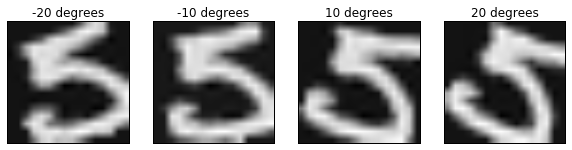

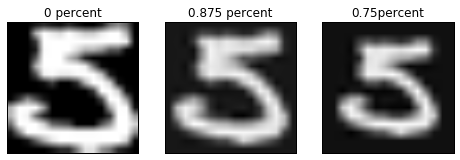

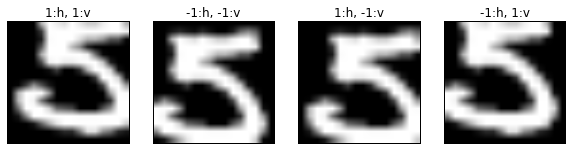

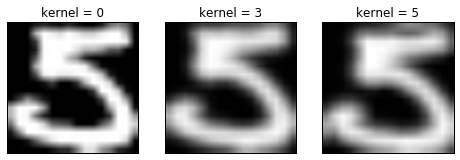

In [2]:
# Loading and showing transformations that will be applied to the train data set before training

os.chdir('/Users/talbotm/Documents/McGill/')
train = np.loadtxt('data/ziptrain.csv')
test = np.loadtxt('data/ziptest.csv')

show_4_rotations(train, [-20, -10, 10, 20])
show_3_shrinks(train, [0, .875, .75])
show_4_shifts(train, [(1,1), (-1,-1), (1, -1), (-1, 1)])
show_3_blur(train, [0, 3, 5])    

<h3><u>ABOVE</u><i></h3>
<ul>
<li>We see the transformations applied to digit 5. These transformations are applied to all digits belonging to the original training data set. Thanks to these transformations, I can generate new instances of digits, which will be used for training models.</li>
</ul>

<h3><u>BELOW</u><i></h3>
<ul>
<li>The dictionnary variable <u>processing</u> contains the transformations applied 
to the train data set. The resulting digits are concatenated to the train data set.</li>
<li>Pay attention to the large number of rows in train_</li>
</ul>

In [3]:
# Enginnering features: transformations shown above are applied to the train data set.

processing = {'rotate': [-40, -35,  -30,  -25, -20,  -15, \
                         -10,  -5,  5, 10, 15, 20, 25, 30, 35, 40], \
              'shrink': [.75, 0.875], \
              'shift': [(2,0), (0,2), (-2,0), (0,-2),\
                        (1,0), (0,1), (-1,0), (0,-1), \
                       (1,1), (-1,1), (-1,1), (-1,-1),\
                       (2,1), (1,2), (-2,1), (1,-2),\
                       (2,-1), (-1,2), (-2,-1), (-1,-2)], \
              'blur': [3] } 

# creating new train data rows
train_ = feature_engineering(train, processing)
# permuting rows
train_ = np.take(train_,np.random.permutation(train_.shape[0]),axis=0)
# scaling mean = 0, std = 1
scaler = preprocessing.StandardScaler().fit(train[:, 1:])
train_[:, 1:] = scaler.transform(train_[:, 1:]) 
test_X = scaler.transform(get_X(test))
test_ = np.append(get_y(test).reshape(-1,1), test_X, axis = 1)

print('Dims of X = ', train_.shape)
print('Dims of y = ', test_.shape)

Dims of X =  (291640, 257)
Dims of y =  (2007, 257)


<h2>I now train these algorithms on a set of train data and test their performance on a set of test data and compare their performance</h2>
<ul>
<li>Random Forest</li>    
<li>Linear Discriminant Analysis</li> 
<li>Support Vector Machine</li> 
<li>GradientBoosting</li>
<li>Extra trees</li>    
<li>Ada boost</li> 
<li>LDA with PCA</li>    
</ul> 

<h3><u>Random Forest</u><i></h3>
<ul>
<li>gridSeach_No_CV is used to test various possible hyper-parameter settings</li>
<li>Note that I used many more parameters values, but I'm only presenting the best performing settings </li>
</ul>

In [ ]:
# Random Forest

RFC = RandomForestClassifier()
# param_grid = {'max_depth': [None],
#               'max_features': [5],
#               'min_samples_split': [2],
#               'min_samples_leaf': [1],
#               'bootstrap': [False],
#               'n_estimators' : [150,155], 
#               'criterion': ['gini'],
#               'n_jobs': [-1],
#               'random_state': [1],
#               'oob_score' : [False]}


param_grid = {'max_depth': [None],
              'max_features': [5],
              'min_samples_split': [2],
              'min_samples_leaf': [1],
              'bootstrap': [False],
              'n_estimators' : [150, 155,160,165, 170], 
              'criterion': ['gini'],
              'n_jobs': [-1],
              'random_state': [1],
              'oob_score' : [False]}

# uncomment to run
#RFC = gridSeach_No_CV(RFC, param_grid, train_, test_) 

In [ ]:
# Below:the output from the function call:
# RFC = gridSeach_No_CV(RFCs, param_grid, train_, test_)
'''
 RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
Accuracy =  0.992127553563 
 RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=155, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
Accuracy =  0.992227204783 
 RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=160, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
Best accuracy =  0.992227204783
Best model =  RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=160, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
'''            

<h3><u>Random Forest: Best Performance</u><i></h3>
<ul>
<li>Best accuracy: 0.992227204783</li>
</ul>


------------------ Model on TEST data on digit: 0 -------------------
          Predicted 0  Predicted 1
Actual 0         1640            8
Actual 1            4          355

------------------ Model on TEST data on digit: 1 -------------------
          Predicted 0  Predicted 1
Actual 0         1740            3
Actual 1            8          256

------------------ Model on TEST data on digit: 2 -------------------
          Predicted 0  Predicted 1
Actual 0         1794           15
Actual 1           10          188

------------------ Model on TEST data on digit: 3 -------------------
          Predicted 0  Predicted 1
Actual 0         1836            5
Actual 1           13          153

------------------ Model on TEST data on digit: 4 -------------------
          Predicted 0  Predicted 1
Actual 0         1798            9
Actual 1           12          188

------------------ Model on TEST data on digit: 5 -------------------
          Predicted 0  Predicted 1
Actual 0      

0.99222720478325876

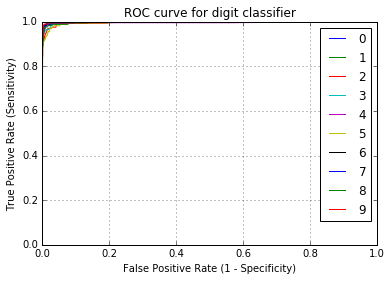

In [4]:
RFC = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=160, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

RFC.fit(get_X(train_),get_y(train_))
classifier_metric(RFC, test_, True)

<h3><u>Linear Discriminant Analysis</u><i></h3>
<ul>
<li>LD does not have hyperparameters, hence param_grid = {}</li>
</ul>

In [5]:
# Linear Discriminant Analysis

LDA = LinearDiscriminantAnalysis()
param_grid = {}

# uncomment to run
#LDA = gridSeach_No_CV(LD, param_grid, train_, test_) 

In [ ]:
# Below:the output from the function call:
# LDA = gridSeach_No_CV(LDA, param_grid, train_, test_)
'''
Accuracy =  0.977080219233 
 LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
Best accuracy =  0.977080219233
Best model =  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
'''

<h3><font color = 'black'><u>LDA: Best Performance</u></font><i></h3>
<ul>
<li>Best accuracy: 0.977080219233 </li>
</ul>


------------------ Model on TEST data on digit: 0 -------------------
          Predicted 0  Predicted 1
Actual 0         1630           18
Actual 1           22          337

------------------ Model on TEST data on digit: 1 -------------------
          Predicted 0  Predicted 1
Actual 0         1676           67
Actual 1            7          257

------------------ Model on TEST data on digit: 2 -------------------
          Predicted 0  Predicted 1
Actual 0         1794           15
Actual 1           60          138

------------------ Model on TEST data on digit: 3 -------------------
          Predicted 0  Predicted 1
Actual 0         1790           51
Actual 1           20          146

------------------ Model on TEST data on digit: 4 -------------------
          Predicted 0  Predicted 1
Actual 0         1780           27
Actual 1           60          140

------------------ Model on TEST data on digit: 5 -------------------
          Predicted 0  Predicted 1
Actual 0      

0.96631788739412061

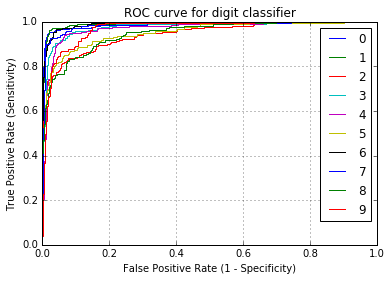

In [5]:
LDA = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

LDA.fit(get_X(train_),get_y(train_))
classifier_metric(LDA, test_, True)

<h3><u>Suport vector Machine</u><i></h3>
<ul>
<li>gridSeach_No_CV is used to test various possible hyper-parameter settings</li>
</ul>

In [ ]:
# Suport vector Machine

SVMC = SVC(probability=True)
param_grid = {'kernel': ['rbf'], 
              'gamma': [ 0.01, 0.1],
              'C': [1, 10]}

# uncomment to run
#SVMC = gridSeach_No_CV(SVMC, param_grid, train_, test_) 

In [ ]:
# Below:the output from the function call:
# SVMC = gridSeach_No_CV(SVMC, param_grid, train_, test_)
'''
Accuracy =  0.989935226707 
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy =  0.884105630294 
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy =  0.99043348281 
 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy =  0.887992027902 
 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best accuracy =  0.99043348281
Best model =  SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)'''

<h3><u>SVM: Best Performance</u><i></h3>
<ul>
<li>Best accuracy: 0.99043348281</li>
</ul>


------------------ Model on TEST data on digit: 0 -------------------
          Predicted 0  Predicted 1
Actual 0         1640            8
Actual 1            4          355

------------------ Model on TEST data on digit: 1 -------------------
          Predicted 0  Predicted 1
Actual 0         1741            2
Actual 1            8          256

------------------ Model on TEST data on digit: 2 -------------------
          Predicted 0  Predicted 1
Actual 0         1796           13
Actual 1           12          186

------------------ Model on TEST data on digit: 3 -------------------
          Predicted 0  Predicted 1
Actual 0         1832            9
Actual 1           16          150

------------------ Model on TEST data on digit: 4 -------------------
          Predicted 0  Predicted 1
Actual 0         1785           22
Actual 1           11          189

------------------ Model on TEST data on digit: 5 -------------------
          Predicted 0  Predicted 1
Actual 0      

0.99043348281016441

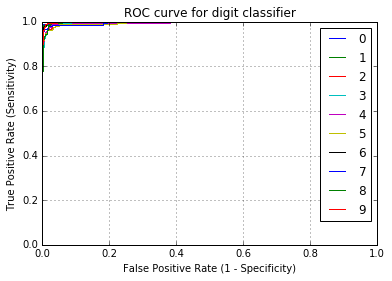

In [11]:
SVMC =  SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVMC.fit(get_X(train_),get_y(train_))
classifier_metric(SVMC, test_, True)

<h3><u>Gradient Boosting</u><i></h3>
<ul>
<li>I used gridSeach_No_CV to test various possible hyper-parameter settings</li>
</ul>

In [ ]:
# GradientBoosting

GBC = GradientBoostingClassifier()
param_grid = {'loss' : ['deviance'],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1],
              'random_state': [7]
              }
# uncomment to run
#GBC = gridSeach_No_CV(GBC, param_grid, train_, test_) 

In [ ]:
# Below:the output from the function call:
# GBC = gridSeach_No_CV(GBC, param_grid, train_, test_) 
'''
Accuracy =  0.987244643747 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987842551071 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987842551071 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.986945690085 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.98764324863 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987543597409 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987244643747 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988639760837 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988739412058 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987742899851 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988141504733 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988241155954 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988141504733 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987942202292 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987942202292 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.98764324863 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988141504733 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988141504733 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987942202292 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988041853513 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988041853513 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987942202292 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988639760837 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988639760837 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.985450921774 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987942202292 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988241155954 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.985052316891 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987045341305 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987443946188 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.985849526657 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987742899851 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987942202292 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.985550572995 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987344294968 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988141504733 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987045341305 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988340807175 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988440458396 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.986846038864 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988141504733 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988340807175 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987742899851 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988540109616 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988540109616 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.987144992526 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988340807175 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.988739412058 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.977379172895 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.981564524165 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.983059292476 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.975984055805 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.980966616841 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.982361733931 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.978276033881 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.981763826607 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.983756851021 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.977080219233 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.980368709517 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.983059292476 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.980368709517 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.983258594918 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.984554060787 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.97947184853 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.982461385152 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.983956153463 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.982461385152 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.984055804684 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.985351270553 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.980667663179 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.983158943697 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy =  0.984853014449 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=150,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)
Best accuracy =  0.988739412058
Best model =  GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)'''

<h3><font color = 'black'><u>Gradient Boosting: Best Performance</u></font><i></h3>
<ul>
<li>Best accuracy: 0.988739412058</li>
</ul>


------------------ Model on TEST data on digit: 0 -------------------
          Predicted 0  Predicted 1
Actual 0         1641            7
Actual 1            5          354

------------------ Model on TEST data on digit: 1 -------------------
          Predicted 0  Predicted 1
Actual 0         1741            2
Actual 1           12          252

------------------ Model on TEST data on digit: 2 -------------------
          Predicted 0  Predicted 1
Actual 0         1792           17
Actual 1           16          182

------------------ Model on TEST data on digit: 3 -------------------
          Predicted 0  Predicted 1
Actual 0         1829           12
Actual 1           19          147

------------------ Model on TEST data on digit: 4 -------------------
          Predicted 0  Predicted 1
Actual 0         1782           25
Actual 1           12          188

------------------ Model on TEST data on digit: 5 -------------------
          Predicted 0  Predicted 1
Actual 0      

0.98873941205779781

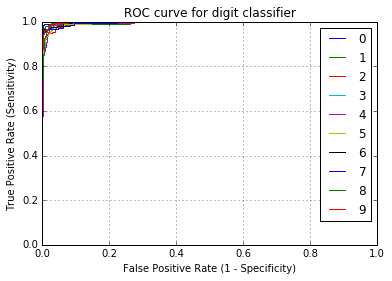

In [7]:
GBC = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=7,
              subsample=1.0, verbose=0, warm_start=False)


GBC.fit(get_X(train_),get_y(train_))
classifier_metric(GBC, test_, True)

<h3><font color = 'black'><u>Extra Trees</u></font><i></h3>
<ul>
<li>gridSeach_No_CV is used to test various possible hyper-parameter settings</li>
</ul>

In [ ]:
# ---------------------
# Extra Trees 

ExtC = ExtraTreesClassifier()
param_grid = {'max_depth': [None],
              'max_features': [1, 3],
              'min_samples_split': [2, 3],
              'min_samples_leaf': [1, 3],
              'bootstrap': [False],
              'n_estimators' :[100,300],
              'criterion': ['gini'],
              'random_state': [7]}

# uncomment to run
#ExtC = gridSeach_No_CV(ExtC, param_grid, train_, test_) 

In [ ]:
# Below:the output from the function call:
# ExtC = gridSeach_No_CV(ExtC, param_grid, train_, test_) 
'''Accuracy =  0.984055804684 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=1, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.985151968112 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=1, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.983756851021 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=1, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.983956153463 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=1, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.973592426507 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=1, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.973492775286 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=1, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.973592426507 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=1, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.973492775286 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=1, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.986547085202 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.987144992526 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.985251619332 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.986846038864 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.983856502242 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.98355754858 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.983856502242 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Accuracy =  0.98355754858 
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)
Best accuracy =  0.987144992526
Best model =  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)'''

<h3><font color = 'black'><u>Extra Trees: Best Performance</u></font><i></h3>
<ul>
<li>Best accuracy: 0.987144992526</li>
</ul>


------------------ Model on TEST data on digit: 0 -------------------
          Predicted 0  Predicted 1
Actual 0         1627           21
Actual 1            6          353

------------------ Model on TEST data on digit: 1 -------------------
          Predicted 0  Predicted 1
Actual 0         1740            3
Actual 1           10          254

------------------ Model on TEST data on digit: 2 -------------------
          Predicted 0  Predicted 1
Actual 0         1791           18
Actual 1           19          179

------------------ Model on TEST data on digit: 3 -------------------
          Predicted 0  Predicted 1
Actual 0         1829           12
Actual 1           18          148

------------------ Model on TEST data on digit: 4 -------------------
          Predicted 0  Predicted 1
Actual 0         1786           21
Actual 1           14          186

------------------ Model on TEST data on digit: 5 -------------------
          Predicted 0  Predicted 1
Actual 0      

0.98714499252615828

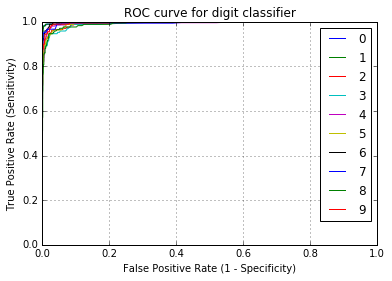

In [8]:

ExtC = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=3, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)

ExtC.fit(get_X(train_),get_y(train_))
classifier_metric(ExtC, test_, True)

<h3><font color = 'black'><u>AdaBoost</u></font><i></h3>
<ul>
<li>gridSeach_No_CV is used to test various possible hyper-parameter settings</li>
</ul>

In [ ]:
# ---------------------
# AdaBoost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC)

param_grid = {'base_estimator__criterion' : ['gini', 'entropy'],
              'base_estimator__splitter' :   ['best', 'random'],
              'algorithm' : ['SAMME','SAMME.R'],
              'n_estimators' :[1,2],
              'learning_rate':  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5],
              'random_state': [7]}

# uncomment to run
#adaDTC = gridSeach_No_CV(adaDTC, param_grid, train_, test_) 

In [ ]:
# Below:the output from the function call:
# adaDTC = gridSeach_No_CV(adaDTC, param_grid, train_, test_) 
'''
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.3, n_estimators=2, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=1, random_state=7)
Accuracy =  0.965620328849 
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=2, random_state=7)
Best accuracy =  0.965620328849
Best model =  AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)
'''

<h3><font color = 'black'><u>AdaBoost: Best Performance</u></font><i></h3>
<ul>
<li>Best accuracy: 0.965620328849</li>
</ul>


------------------ Model on TEST data on digit: 0 -------------------
          Predicted 0  Predicted 1
Actual 0         1607           41
Actual 1           30          329

------------------ Model on TEST data on digit: 1 -------------------
          Predicted 0  Predicted 1
Actual 0         1728           15
Actual 1           17          247

------------------ Model on TEST data on digit: 2 -------------------
          Predicted 0  Predicted 1
Actual 0         1761           48
Actual 1           43          155

------------------ Model on TEST data on digit: 3 -------------------
          Predicted 0  Predicted 1
Actual 0         1802           39
Actual 1           38          128

------------------ Model on TEST data on digit: 4 -------------------
          Predicted 0  Predicted 1
Actual 0         1763           44
Actual 1           38          162

------------------ Model on TEST data on digit: 5 -------------------
          Predicted 0  Predicted 1
Actual 0      

0.9656203288490286

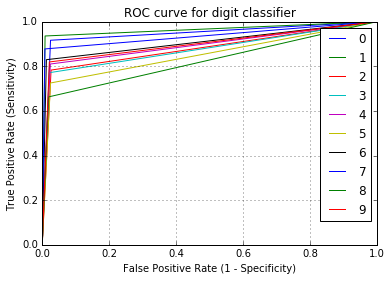

In [9]:
adaDTC =  AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)

adaDTC.fit(get_X(train_),get_y(train_))
classifier_metric(adaDTC, test_, True)

<h3><font color = 'black'><u>PCA with LDA: Optimal Number of Components</u></font><i></h3>
<ul>
<li>I realize that I could have used PCA as a preprocesson step on all models, but I limited myself to LDA because I have limited computational power, which translate into long waiting time.</li>
</ul>

Highest accuracy of 0.9770802192326856 with 203 component


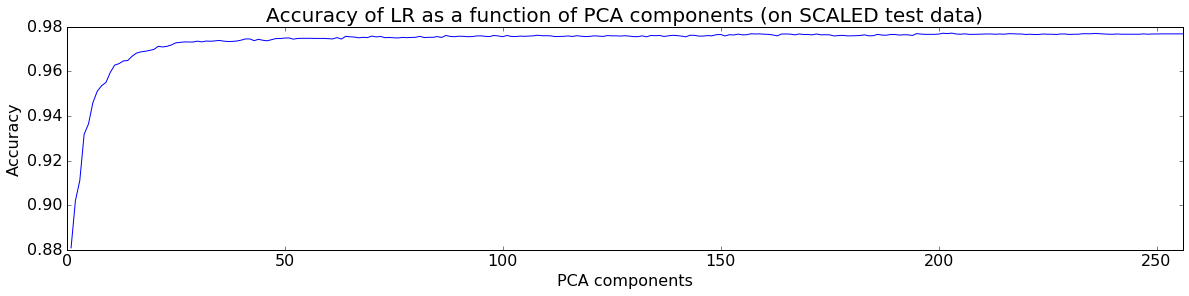

In [10]:
# PCA & models
ld = LinearDiscriminantAnalysis()
components = list(range(1, train[0,:].shape[0])) 
accuracy_m = []

for m in components:
    pca = PCA(n_components = m)
    pca.fit(train_[:, 1:])
    Z_train_ = pca.transform(train_[:,1:])
    ld.fit(Z_train_, train_[:, 0])
    Z_test_ = pca.transform(test_[:,1:])
    temp_digit_accuracy = []
    
    # binarization of digits for confusion matrix: 
    for i in range(1,10):
        y_ = (test_[:,0] == i).astype(int)
        y_pred_ = np.array(ld.predict(Z_test_) == i).astype(int) 
        temp_digit_accuracy.append(precision(y_, y_pred_))  
    accuracy_m.append(np.array(temp_digit_accuracy).mean(axis=0))  
    
plt.subplots(figsize=(20,4))
plt.plot(components, accuracy_m)
plt.title('Accuracy of LR as a function of PCA components (on SCALED test data)',size=20)
plt.xlabel('PCA components',size=16)
plt.ylabel('Accuracy',size=16)
plt.xlim(0,256)
plt.tick_params(labelsize=16)
print('Highest accuracy of {} with {} component'\
      .format(np.max(accuracy_m),np.where(accuracy_m == np.max(accuracy_m))[0][0]+1))

<h3><font color = 'black'><u>PCA with LDA:: Best Performance</u></font><i></h3>
<ul>
<li>Best accuracy: 97.7%</li>
</ul>